## レーティング

elo ratingを計算する.

とりあえず、シンプルなelo ratingを実装する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def elo_rating(win_rate: float, lose_rate: float, rate_base: float = 1500) -> float:
    """
    イロレーティングの本質は、勝敗比を対数に変換したもの

    Parameters
    -----
    win_rate: float
        勝率
    lose_rate: float
        負け率
    rate_base: float
        基準となるレーティング. 勝つ確率と負ける確率が同じ場合このレートになる
    """
    return 400 * np.log10(win_rate / lose_rate) + rate_base

In [3]:
def win_rate(rate: float, rate_other: float, h = 0) -> float:
    """
    第一引数のratingに対する第二引数のratingの勝率

    Parameters
    -----
    rate: float
        勝率を計算する対象のレーティング
    rate_other: float
        勝率を計算する対象の相手のレーティング
    h : int
        レーティング以外の環境要因の補正
    """
    return 1 / (10 ** ((rate_other - rate + h) / 400) + 1)

In [4]:
def update_rate(rate: float, n_wins: int, n_games: int, win_rate: float, k: int=32):
    """
    ゲームの結果を元にratingを更新する

    Parameters
    -----
    rate: float
        更新元のrating
    n_wins: int
        勝った回数
    n_games: int
        実施されたゲーム数
    win_rate: float
        実際に買った回数

    Notes
    -----
    実際に勝った数と勝率の期待値を比較して、kで更新
    kが大きいと収束に時間が短いが、レートの変化が大きく不安定
    kが小さいと収束に時間が長いが、レートの変化は小さく安定する
    """
    return rate + k * (n_wins - n_games * win_rate)

## モンテカルロシミュレーションによる検証

### Playerの定義

In [5]:
# Player名
players = ["A", "B", "C", "D", "E", "F"]

# 真のレートを設定しておく
# 実装が正しければここに収束する
true_rate = {
    "A": 2000,
    "B": 1800,
    "C": 1600,
    "D": 1400,
    "E": 1200,
    "F": 1000,
}


### 実施

In [6]:
current_rate = {p: 1500 for p in players}  # スタート時のレートは全員1500とする
n = 2000  # 試合数
logs = []  # ratingの変化を記録する配列


# 乱数用
rnd_gen = np.random.default_rng(43)
for _ in tqdm(range(n)):
    # ランダムにシミュレーションするplayerを選択
    player_a, player_b = rnd_gen.choice(players, 2, replace=False)
    
    # 実際のレーティングをもとに勝敗をシミュレーション
    true_win_rate_a = win_rate(true_rate[player_a], true_rate[player_b])
    is_a_win = true_win_rate_a >= rnd_gen.random()

    # 現在のoddsからの勝率を計算する
    win_rate_a_current_odds = win_rate(current_rate[player_a], current_rate[player_b])
    
    # レーティングの更新
    # 番狂せが起きれば変化が大きくなる -> ここの勝率では真の勝率ではなく、今のoddsから計算される勝率
    new_rate_a = update_rate(
        rate=current_rate[player_a],
        n_wins=is_a_win,
        n_games=1,
        win_rate=win_rate_a_current_odds,
    )
    
    new_rate_b = update_rate(
        rate=current_rate[player_b],
        n_wins=1-is_a_win,
        n_games=1,
        win_rate=1-win_rate_a_current_odds,
    )
    current_rate[player_a] = new_rate_a
    current_rate[player_b] = new_rate_b

    # 記録
    log_data = current_rate.copy()
    log_data["player_a"] = player_a
    log_data["player_b"] = player_b
    log_data["win"] = player_a if is_a_win else player_b
    log_data["is_a_win"] = is_a_win
    log_data["true_win_rate_a"] = true_win_rate_a
    logs.append(log_data)

# logをDataFrameに変換
result = pd.DataFrame(logs)

  0%|          | 0/2000 [00:00<?, ?it/s]

### 可視化

In [7]:
# 確認
display(result.head(10))

,A,B,C,D,E,F,player_a,player_b,win,is_a_win,true_win_rate_a
0,1500.000000,1500.000000,1484.000000,1516.000000,1500.000000,1500.000000,D,C,D,True,0.240253
1,1516.000000,1484.000000,1484.000000,1516.000000,1500.000000,1500.000000,A,B,A,True,0.759747
2,1516.000000,1500.736307,1484.000000,1516.000000,1483.263693,1500.000000,E,B,B,False,0.030653
3,1516.000000,1517.438774,1484.000000,1499.297533,1483.263693,1500.000000,B,D,B,True,0.909091
4,1531.263693,1517.438774,1484.000000,1499.297533,1483.263693,1484.736307,F,A,A,False,0.003152
5,1531.263693,1517.438774,1484.000000,1499.297533,1499.331509,1468.668491,F,E,E,False,0.240253
6,1513.100447,1517.438774,1502.163246,1499.297533,1499.331509,1468.668491,A,C,C,False,0.909091
7,1529.300224,1501.238997,1502.163246,1499.297533,1499.331509,1468.668491,B,A,A,False,0.240253
8,1529.300224,1501.238997,1516.625516,1499.297533,1499.331509,1454.206220,C,F,C,True,0.969347
9,1529.300224,1501.238997,1516.625516,1499.297533,1481.265020,1472.272710,E,F,F,False,0.759747


True rating:  {'A': 2000, 'B': 1800, 'C': 1600, 'D': 1400, 'E': 1200, 'F': 1000}


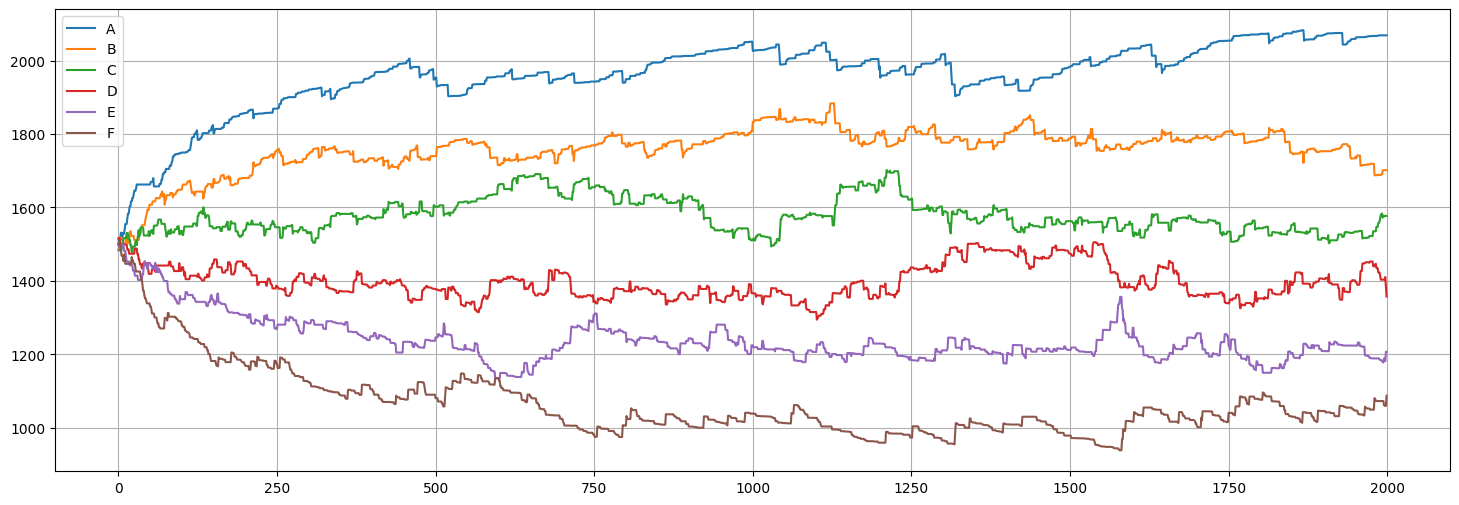

In [8]:
print("True rating: ", true_rate)

fig, ax = plt.subplots(figsize=(18, 6))

result[players].plot(kind="line", ax=ax)

ax.grid()